# 第5章　PyTorchを使った畳み込みネットワーク







In [0]:
!pip install torchvision==0.2.1
!pip install pillow==4.2.0

    100% |████████████████████████████████| 61kB 2.7MB/s 
    100% |████████████████████████████████| 519.5MB 33kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5999e000 @  0x7f8625cc51c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 2.0MB 3.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.8MB 873kB/s 
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0


In [0]:
import torch
torch.__version__

'0.4.1'

# 独自データセットを畳み込みニューラルネットで画像分類

In [7]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip


Redirecting output to ‘wget-log.1’.
Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

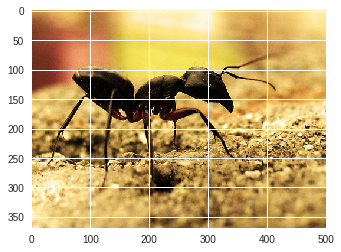

In [34]:
import cv2
#画像の読み込み
img = cv2.imread('./hymenoptera_data/train/ants/649026570_e58656104b.jpg')
#画像のチャンネルをbgrからrgbに変換
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#画像を表示
plt.imshow(img)
plt.show()

In [0]:
#画像の前処理を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
#画像とラベルを読み込む
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                             shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,
                                             shuffle=False, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [50]:
for train in train_loader:
    print(train[0].shape)
    print(train[0].dtype)
    break

torch.Size([4, 3, 224, 224])
torch.float32


In [0]:
#重み初期化の関数定義
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [52]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


In [0]:
#ネットワークrenset18の定義
net = models.resnet18(pretrained=False)
net = net.to(device)
#重み初期化
net.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [41]:
num_epochs = 200

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train==============================
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val==============================
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/200], Loss: 0.5781, val_loss: 1.0392, val_acc: 0.3856
Epoch [2/200], Loss: 0.2265, val_loss: 2.9756, val_acc: 0.4575
Epoch [3/200], Loss: 0.2924, val_loss: 0.2466, val_acc: 0.5490
Epoch [4/200], Loss: 0.2388, val_loss: 0.1709, val_acc: 0.5882
Epoch [5/200], Loss: 0.2293, val_loss: 0.3212, val_acc: 0.4641
Epoch [6/200], Loss: 0.2077, val_loss: 0.4748, val_acc: 0.5425
Epoch [7/200], Loss: 0.2269, val_loss: 0.1630, val_acc: 0.6601
Epoch [8/200], Loss: 0.2014, val_loss: 0.2394, val_acc: 0.5490
Epoch [9/200], Loss: 0.1832, val_loss: 0.1690, val_acc: 0.5948
Epoch [10/200], Loss: 0.2077, val_loss: 0.1635, val_acc: 0.6405
Epoch [11/200], Loss: 0.1906, val_loss: 0.1817, val_acc: 0.6471
Epoch [12/200], Loss: 0.1815, val_loss: 0.1545, val_acc: 0.6471
Epoch [13/200], Loss: 0.1903, val_loss: 0.1416, val_acc: 0.7059
Epoch [14/200], Loss: 0.1878, val_loss: 0.1618, val_acc: 0.6732
Epoch [15/200], Loss: 0.1876, val_loss: 0.1550, val_acc: 0.6993
Epoch [16/200], Loss: 0.1677, val_loss: 0.1345, v

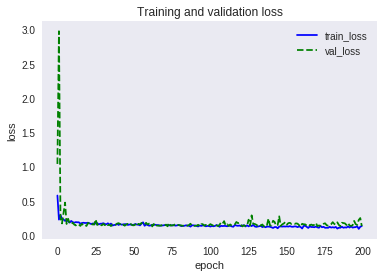

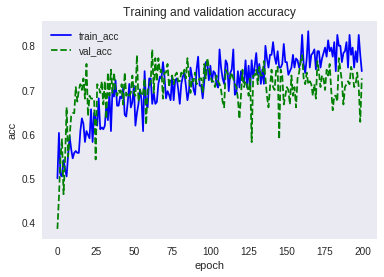

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## 転移学習


In [0]:
#学習済みのresnet18を読み込み
net = models.resnet18(pretrained=True)
#ネットワークのパラメータを凍結
for param in net.parameters():
    param.requires_grad = False
net = net.to(device)
#最終層を2クラス用に変更
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2).to(device)

In [0]:
#最適化関数の学習率を小さめに設定
criterion = nn.CrossEntropyLoss()
#ここ入れたいなぁ。。
# resnet_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

In [56]:
num_epochs = 200

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train==============================
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val==============================
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/200], Loss: 0.1786, val_loss: 0.1641, val_acc: 0.6209
Epoch [2/200], Loss: 0.1542, val_loss: 0.1298, val_acc: 0.7320
Epoch [3/200], Loss: 0.1380, val_loss: 0.0987, val_acc: 0.8693
Epoch [4/200], Loss: 0.1249, val_loss: 0.0997, val_acc: 0.8758
Epoch [5/200], Loss: 0.1131, val_loss: 0.0813, val_acc: 0.8954
Epoch [6/200], Loss: 0.1120, val_loss: 0.0769, val_acc: 0.9020
Epoch [7/200], Loss: 0.1107, val_loss: 0.0696, val_acc: 0.9346
Epoch [8/200], Loss: 0.1151, val_loss: 0.0668, val_acc: 0.9216
Epoch [9/200], Loss: 0.1062, val_loss: 0.0671, val_acc: 0.8824
Epoch [10/200], Loss: 0.0947, val_loss: 0.0651, val_acc: 0.9412
Epoch [11/200], Loss: 0.0916, val_loss: 0.0570, val_acc: 0.9477
Epoch [12/200], Loss: 0.1032, val_loss: 0.0584, val_acc: 0.9020
Epoch [13/200], Loss: 0.1030, val_loss: 0.0579, val_acc: 0.9216
Epoch [14/200], Loss: 0.0996, val_loss: 0.0524, val_acc: 0.9477
Epoch [15/200], Loss: 0.1054, val_loss: 0.0545, val_acc: 0.9412
Epoch [16/200], Loss: 0.0870, val_loss: 0.0565, v

Process Process-7108:
Process Process-7106:
Process Process-7105:
Process Process-7107:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", lin

KeyboardInterrupt: ignored

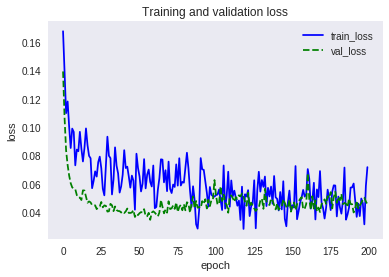

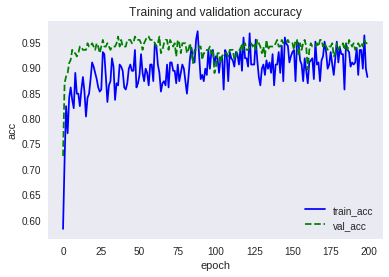

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()